# Convolutional Neural Network

In [1]:
import pandas as pd
from finlab.data import Data
data = Data()
twii = data.get("發行量加權股價指數")
twii = twii['台股指數']
twii = twii.resample('1D').first().dropna()

ModuleNotFoundError: No module named 'requests'

In [ ]:
#twii

In [53]:
##t1 = indexes.tolist()
##print(indexs)

## 製作features

In [195]:
import numpy as np
import tqdm
time_period = 200
target_time = 7 #n個時間點後的收盤價

cnn_x = []
cnn_y = []
indexs = []
for i in tqdm.notebook.tqdm(range(0, len(twii) - time_period - 1 - target_time, 2)):#漲跌幅度，n個時間點後的收盤價
    s = twii.iloc[i:i+time_period].values
    cnn_x.append((s - s.min())/(s.max() - s.min()))
    
    r = twii.iloc[i+time_period+target_time] / twii.iloc[i+time_period-1] #漲跌幅度，n個時間點後的收盤價
    cnn_y.append(r)
    
    indexs.append(twii.index[i+time_period-1])

cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)




  0%|          | 0/2028 [00:00<?, ?it/s]

1.0053748014988082


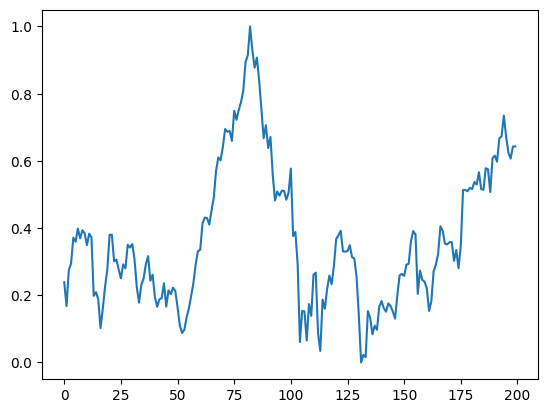

In [196]:
import matplotlib.pyplot as plt

plt.plot(cnn_x[0])
print(cnn_y[0])

In [197]:
from ipywidgets import interact

@interact(x=(0, 100, 10))
def p(x=80):
    pass

interactive(children=(IntSlider(value=80, description='x', step=10), Output()), _dom_classes=('widget-interact…

## Reshape features and labels

In [198]:
cnn_x.shape

(2028, 200)

In [199]:
cnn_x = cnn_x.reshape(len(cnn_x), time_period, 1)
cnn_y = cnn_y.reshape(len(cnn_y), 1)

## Split traning and testing data

In [210]:
import datetime
cnn_x_train = cnn_x[indexes < datetime.datetime(2022,1,1)]
cnn_y_train = cnn_y[indexes < datetime.datetime(2022,1,1)]

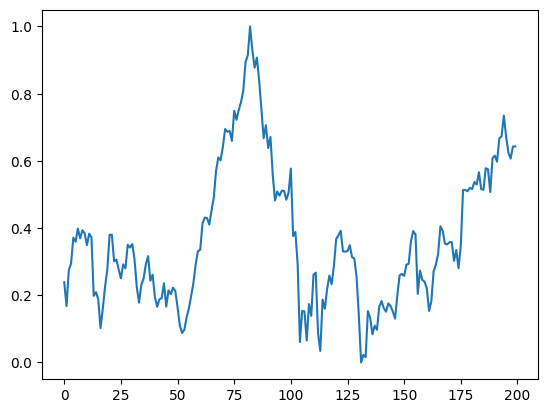

In [211]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cnn_x[0].reshape(1, len(cnn_x[0]))[0])


## CNN

In [212]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = cnn_x[0].shape
num_classes = 1

model = keras.Sequential()

model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=20, activation='relu', input_shape=cnn_x[0].shape))
model.add(tf.keras.layers.AveragePooling1D(5))

model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=20, activation='relu'))
model.add(tf.keras.layers.AveragePooling1D(5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=120, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=84, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(units=26, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=1, ))#activation = 'softmax'))


##adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)
adam = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, amsgrad=False)


#model.compile(loss='mse',
#                optimizer=adam)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["accuracy"],
)

print(model.summary())


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 181, 20)           420       
                                                                 
 average_pooling1d_20 (Avera  (None, 36, 20)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_21 (Conv1D)          (None, 17, 20)            8020      
                                                                 
 average_pooling1d_21 (Avera  (None, 3, 20)            0         
 gePooling1D)                                                    
                                                                 
 flatten_10 (Flatten)        (None, 60)                0         
                                                                 
 dense_40 (Dense)            (None, 120)             

In [213]:
history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=200,
                    epochs=500,
                    verbose=1,
                    validation_split=0.1,
                    #callbacks=[get_best_model]
                   )

Epoch 1/500
9/9 [==============================] - 1s 32ms/step - loss: 0.4423 - accuracy: 0.0000e+00 - val_loss: 0.0286 - val_accuracy: 0.0000e+00
Epoch 2/500
9/9 [==============================] - 0s 15ms/step - loss: 0.1968 - accuracy: 0.0000e+00 - val_loss: 0.1000 - val_accuracy: 0.0000e+00
Epoch 3/500
9/9 [==============================] - 0s 15ms/step - loss: 0.1517 - accuracy: 0.0000e+00 - val_loss: 0.0412 - val_accuracy: 0.0000e+00
Epoch 4/500
9/9 [==============================] - 0s 14ms/step - loss: 0.1216 - accuracy: 0.0000e+00 - val_loss: 0.0442 - val_accuracy: 0.0000e+00
Epoch 5/500
9/9 [==============================] - 0s 13ms/step - loss: 0.0997 - accuracy: 0.0000e+00 - val_loss: 0.0192 - val_accuracy: 0.0000e+00
Epoch 6/500
9/9 [==============================] - 0s 14ms/step - loss: 0.0841 - accuracy: 0.0000e+00 - val_loss: 0.0159 - val_accuracy: 0.0000e+00
Epoch 7/500
9/9 [==============================] - 0s 14ms/step - loss: 0.0763 - accuracy: 0.0000e+00 - val_loss

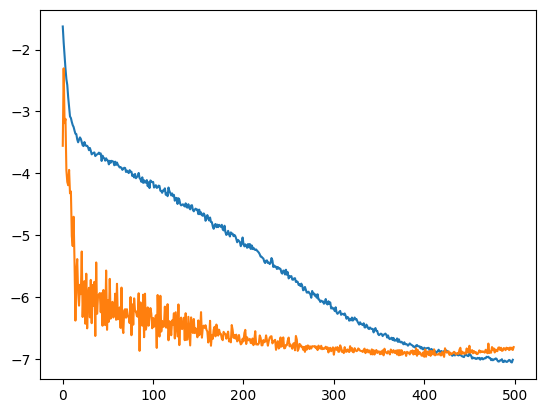

In [214]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][1:]))
plt.plot(np.log(history.history['val_loss']))

In [215]:
ey = model.predict(cnn_x)
ey = pd.Series(ey.swapaxes(0, 1)[0], index=indexes)

64/64 [==============================] - 0s 2ms/step


<AxesSubplot:>

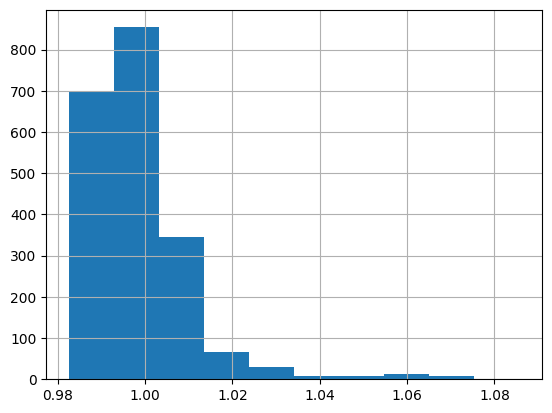

In [216]:
ey.hist()

<AxesSubplot:xlabel='date'>

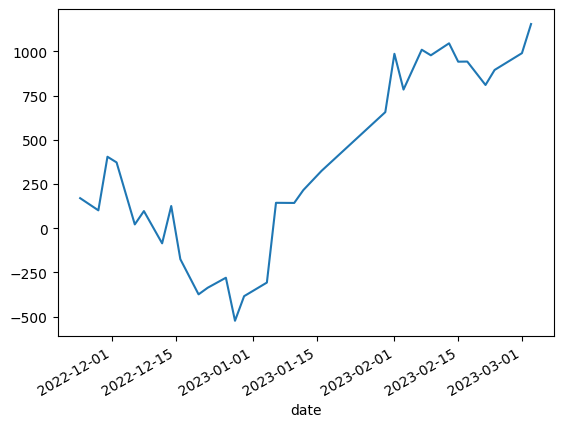

In [217]:

eq = twii[pd.to_datetime(indexes)]
gain = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.9)).rolling(25).sum() > 0
eq = (gain[signal])['2022':].cumsum()
eq.plot()

In [218]:
signal['2022':].astype(int).diff().abs().sum()

2.0

In [219]:
signal_true = signal[signal].dropna()
signal_true[-30:]

2022-11-28    True
2022-11-30    True
2022-12-02    True
2022-12-06    True
2022-12-08    True
2022-12-12    True
2022-12-14    True
2022-12-16    True
2022-12-20    True
2022-12-22    True
2022-12-26    True
2022-12-28    True
2022-12-30    True
2023-01-04    True
2023-01-06    True
2023-01-10    True
2023-01-12    True
2023-01-16    True
2023-01-30    True
2023-02-01    True
2023-02-03    True
2023-02-07    True
2023-02-09    True
2023-02-13    True
2023-02-15    True
2023-02-17    True
2023-02-21    True
2023-02-23    True
2023-03-01    True
2023-03-03    True
dtype: bool